In [1]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Dataset paths
image_dir = r"C:\Users\mohammad\Downloads\tiff\images"
mask_dir = r"C:\Users\mohammad\Downloads\tiff\masks"

# Loading data
def load_data(image_dir, mask_dir):
    images = []
    masks = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file.replace('.tiff', '.tif'))  # Matching mask extension
        
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
        
        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)
    
    return np.array(images), np.array(masks)

images, masks = load_data(image_dir, mask_dir)


In [2]:

# Building the U-Net model
def build_unet(input_shape):
    inputs = layers.Input(input_shape)
    
    # Down-sampling
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Up-sampling
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    return models.Model(inputs, outputs)

model = build_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))


In [3]:

# Defining Dice loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])


In [5]:

# Saving the best model
model_save_path = "unet_model.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Training the model
history = model.fit(
    images, masks,
    batch_size=16,
    epochs=20,
    validation_split=0.1,
    callbacks=[checkpoint]
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1675 - loss: 0.8960
Epoch 1: val_loss improved from inf to 0.91093, saving model to unet_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.1703 - loss: 0.8957 - val_accuracy: 0.6141 - val_loss: 0.9109
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6553 - loss: 0.8424
Epoch 2: val_loss improved from 0.91093 to 0.90788, saving model to unet_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6552 - loss: 0.8423 - val_accuracy: 0.9643 - val_loss: 0.9079
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6562 - loss: 0.8447
Epoch 3: val_loss improved from 0.90788 to 0.89682, saving model to unet_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6577 - loss: 0.8441 - val_accuracy: 0.7298 - val_loss: 0.8968
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8661 - loss: 0.7472
Epoch 4: val_loss improved from 0.89682 to 0.83907, saving model to unet

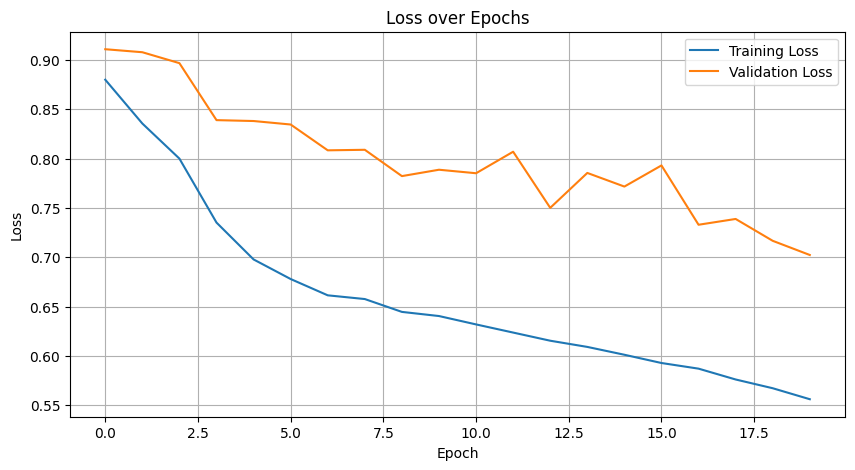

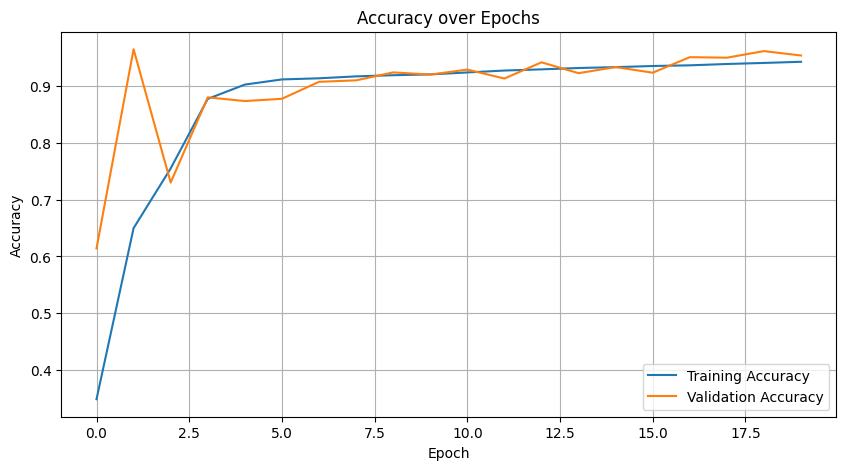

In [6]:

# Plotting metrics
def plot_metrics(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted mask saved as predicted_new_mask.png


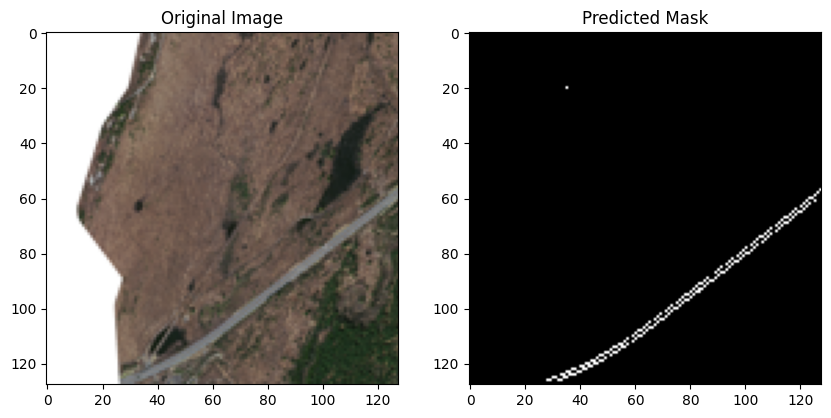

In [25]:

# Function to predict mask for a new image
def predict_new_image(model, image_path, output_path="predicted_new_mask.png"):
    # Load and preprocess image
    original_img = Image.open(image_path).convert("RGB").resize((IMG_HEIGHT, IMG_WIDTH))
    img_array = np.array(original_img) / 255.0  # Normalize
    img_array = img_array[np.newaxis, ...]  # Add batch dimension

    # Predict mask
    predicted_mask = model.predict(img_array)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Binarize mask

    # Save predicted mask
    predicted_image = Image.fromarray((predicted_mask.squeeze() * 255).astype(np.uint8))
    predicted_image.save(output_path)
    print(f"Predicted mask saved as {output_path}")

    # Display original image and predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img)

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask.squeeze(), cmap="gray")
    plt.show()

# Call the function to predict a new image
predict_new_image(model, r"C:\Users\mohammad\Downloads\tiff\images\10228780_15.tiff")